<a href="https://colab.research.google.com/github/EmmaMuhleman1/Adv_Fin_ML_Exercises/blob/master/GEM_NASDAQ_100_XGBoost_Prediction_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Environment setup

In [87]:
!pip install yfinance pandas numpy scikit-learn matplotlib seaborn plotly ta xgboost

# --- Import Libraries ---
import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Technical Analysis
import ta

# Scikit-learn for preprocessing, modeling, and evaluation
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve

# Settings for better visualization
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

## 1. Introduction: Predicting NASDAQ-100 Next-Day Returns

This notebook outlines a complete workflow to build a binary classification model for predicting the direction of the next day's return for the NASDAQ-100 index. A positive return will be labeled as `1`, and a non-positive (zero or negative) return will be labeled as `0`.

The core of this analysis will use the **XGBoost** algorithm, a highly efficient and powerful implementation of gradient boosting. Key steps include:
- **Data Ingestion:** Fetching historical daily data for the NASDAQ-100 (`^NDX`).
- **Feature Engineering:** Creating a diverse set of technical and momentum-based indicators.
- **Target Definition:** Defining the target variable based on the *next day's* price movement.
- **Model Training:** Using `RandomizedSearchCV` for efficient hyperparameter optimization, tailored for time-series data with `TimeSeriesSplit`.
- **Class Imbalance:** Explicitly addressing the typical imbalance between positive and non-positive return days using XGBoost's `scale_pos_weight` parameter.
- **Evaluation:** Rigorously assessing the model's performance on an unseen test set using metrics relevant to a trading context, such as the ROC AUC score, confusion matrix, and a detailed classification report.

---
## 2. Data Ingestion and Preparation

We begin by fetching daily historical Open, High, Low, Close, and Volume (OHLCV) data for the NASDAQ-100 index (`^NDX`) from Yahoo Finance. We will then calculate daily log returns, which will serve as the basis for our target variable.

In [88]:
# Cell 2: Data Ingestion and Log Return Calculation
ticker_symbol = "^NDX"
start_date = "2010-01-01"
end_date = datetime.now().strftime('%Y-%m-%d')

# --- Download Data ---
try:
    data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)
    if data.empty:
        raise ValueError("No data fetched. Check ticker symbol or date range.")
    print(f"Successfully fetched {len(data)} rows of data for {ticker_symbol} from {start_date} to {end_date}")
except Exception as e:
    print(f"Error fetching data: {e}")
    # Create placeholder data if download fails
    data = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='B'))
    data['Close'] = np.cumprod(1 + np.random.normal(0.0005, 0.015, size=len(data))) * 3000
    data['Volume'] = np.random.randint(1e9, 5e9, size=len(data))
    for col in ['Open', 'High', 'Low', 'Close']:
        data[col] = data['Close']

# --- Simplify column names ---
# yfinance >= 0.2.38 returns a MultiIndex. Flatten it.
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# --- Calculate Log Returns ---
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))

Successfully fetched 3899 rows of data for ^NDX from 2010-01-01 to 2025-07-07


/tmp/ipython-input-88-3550482330.py:8: FutureWarning:

YF.download() has changed argument auto_adjust default to True



In [89]:
data

Price,Close,High,Low,Open,Volume,LogReturn
Date,,,,,,
2010-01-04,1886.699951,1890.020020,1881.630005,1882.689941,1931380000,NaN
2010-01-05,1888.430054,1891.329956,1877.520020,1887.280029,2367860000,0.000917
2010-01-06,1878.420044,1893.209961,1873.900024,1887.910034,2253340000,-0.005315
2010-01-07,1876.719971,1881.329956,1867.619995,1878.160034,2270050000,-0.000905
2010-01-08,1892.589966,1893.250000,1868.550049,1870.900024,2145390000,0.008421
...,...,...,...,...,...,...
2025-06-27,22534.199219,22603.220703,22382.789062,22484.869141,10951070000,0.003864
2025-06-30,22679.009766,22721.500000,22565.109375,22632.919922,8220420000,0.006406
2025-07-01,22478.130859,22631.259766,22388.089844,22594.480469,8631710000,-0.008897


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3899 entries, 2010-01-04 to 2025-07-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      3899 non-null   float64
 1   High       3899 non-null   float64
 2   Low        3899 non-null   float64
 3   Open       3899 non-null   float64
 4   Volume     3899 non-null   int64  
 5   LogReturn  3898 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 213.2 KB


In [91]:
# --- Calculate Log Returns ---
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))

In [92]:
# --- Display Data ---
print("\nData Head:")
print(data.head())
print("\nData Tail:")
print(data.tail())


Data Head:
Price             Close         High          Low         Open      Volume  \
Date                                                                         
2010-01-04  1886.699951  1890.020020  1881.630005  1882.689941  1931380000   
2010-01-05  1888.430054  1891.329956  1877.520020  1887.280029  2367860000   
2010-01-06  1878.420044  1893.209961  1873.900024  1887.910034  2253340000   
2010-01-07  1876.719971  1881.329956  1867.619995  1878.160034  2270050000   
2010-01-08  1892.589966  1893.250000  1868.550049  1870.900024  2145390000   

Price       LogReturn  
Date                   
2010-01-04        NaN  
2010-01-05   0.000917  
2010-01-06  -0.005315  
2010-01-07  -0.000905  
2010-01-08   0.008421  

Data Tail:
Price              Close          High           Low          Open  \
Date                                                                 
2025-06-27  22534.199219  22603.220703  22382.789062  22484.869141   
2025-06-30  22679.009766  22721.500000  22565.10937

In [93]:
# Drop rows with NaN values (the first row will have NaN for LogReturn)
data = data.dropna()

In [94]:
# --- Plot Data ---
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    subplot_titles=(f'{ticker_symbol} Adjusted Closing Price', f'{ticker_symbol} Daily Log Returns'))
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['LogReturn'], name='Log Return', line=dict(color='orangered')), row=2, col=1)
fig.update_layout(height=600, title_text=f'{ticker_symbol} Price and Log Returns ({start_date} - {end_date})',
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
fig.show()

---
## 3. Target Variable Definition and Class Balance

Our goal is to predict if the **next day's** return will be positive.

- **Target `y` at time `t`**: `1` if the log return at time `t+1` is greater than 0, otherwise `0`.
- **Features `X` at time `t`**: All indicators and features calculated using data known up to and including time `t`.

This setup ensures there is no lookahead bias; we are using today's information to predict tomorrow's outcome.

In [95]:
# Cell 3: Define Target Variable (Next Day's Return Direction)

# The signal for day 't' is based on the return of day 't+1'
data['Signal'] = (data['LogReturn'].shift(-1) > 0).astype(int)

/tmp/ipython-input-95-3568487413.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [96]:
# --- Analyze Class Distribution ---
print("Distribution of the Target Variable (Signal):")
signal_counts = data['Signal'].value_counts()
signal_pct = data['Signal'].value_counts(normalize=True)
print(signal_counts)
print("\nPercentage Distribution:")
print(signal_pct)

Distribution of the Target Variable (Signal):
Signal
1    2169
0    1729
Name: count, dtype: int64

Percentage Distribution:
Signal
1    0.556439
0    0.443561
Name: proportion, dtype: float64


In [97]:
# Plot the distribution
fig = go.Figure(data=[go.Bar(x=signal_pct.index,
                             y=signal_pct.values,
                             text=[f'{p:.2%}' for p in signal_pct.values],
                             textposition='auto',
                             marker_color=['#0047AB', '#FF4500'])]) # Blue for Up, Red for Down/Flat
fig.update_layout(title_text='Target Variable Distribution (1: Next Day Up, 0: Next Day Non-Positive)',
                  xaxis=dict(title='Signal', tickvals=[0, 1], ticktext=['Non-Positive (0)', 'Positive (1)']),
                  yaxis=dict(title='Proportion', tickformat=".0%"))
fig.show()

The slight class imbalance is typical. We will address it later during the model development phase.

---
## 4. Feature Engineering

We will now engineer a comprehensive set of features from the historical data. These features are designed to capture different aspects of market dynamics, including momentum, volatility, and trend. All features are calculated based on information available at time `t`.**bold text**

In [98]:
df = data.copy()

In [99]:
# --- Momentum Features ---
for n in [5, 10, 21, 63, 252]: # ~1W, 2W, 1M, 3M, 1Y
    df[f'mom_{n}'] = df['LogReturn'].rolling(window=n).sum()

In [100]:
# --- Volatility Features ---
for n in [10, 21, 63]:
    df[f'vol_{n}'] = df['LogReturn'].rolling(window=n).std() * np.sqrt(252) # Annualized

In [101]:
# --- Lagged Returns ---
for n in range(1, 6):
    df[f'lag_{n}'] = df['LogReturn'].shift(n)

In [102]:
# --- Moving Average Features ---
for n in [10, 21, 50, 200]:
    df[f'sma_{n}'] = df['Close'].rolling(window=n).mean()
    df[f'price_sma_{n}_ratio'] = df['Close'] / df[f'sma_{n}']

In [103]:
# --- Technical Indicators from 'ta' library ---
# Relative Strength Index (RSI)
df['rsi'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()
# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['macd_diff'] = macd.macd_diff()
# Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
df['bb_width'] = bollinger.bollinger_wband()
df['bb_pct'] = bollinger.bollinger_pband()
# Average True Range (ATR)
df['atr'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14).average_true_range()
# Volume-based
df['volume_sma_20'] = df['Volume'].rolling(window=20).mean()
df['volume_ratio'] = df['Volume'] / df['volume_sma_20']


In [104]:
# --- Finalize Feature and Target Sets ---
feature_cols = [
    'mom_5', 'mom_10', 'mom_21', 'mom_63', 'mom_252',
    'vol_10', 'vol_21', 'vol_63',
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
    'price_sma_10_ratio', 'price_sma_21_ratio', 'price_sma_50_ratio', 'price_sma_200_ratio',
    'rsi', 'macd_diff', 'bb_width', 'bb_pct', 'atr', 'volume_ratio'
]

In [105]:
# Define X and y
X = df[feature_cols]
y = df['Signal']

In [106]:
# Drop rows with NaN values (resulting from rolling windows and target shift)
# This aligns X and y perfectly.
combined = pd.concat([X, y], axis=1).dropna()
X = combined[feature_cols]
y = combined['Signal']

In [107]:
print(f"Shape of feature matrix X: {X.shape}")
print(f"Shape of target vector y: {y.shape}")
print("\nFinal features being used:")
print(X.columns.tolist())

Shape of feature matrix X: (3647, 23)
Shape of target vector y: (3647,)

Final features being used:
['mom_5', 'mom_10', 'mom_21', 'mom_63', 'mom_252', 'vol_10', 'vol_21', 'vol_63', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'price_sma_10_ratio', 'price_sma_21_ratio', 'price_sma_50_ratio', 'price_sma_200_ratio', 'rsi', 'macd_diff', 'bb_width', 'bb_pct', 'atr', 'volume_ratio']


---
## 5. Split into Train/Test Sets and Scale Features

In [108]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

if X.empty or y.empty:
    print("Feature matrix X or target y is empty. Cannot proceed.")
else:
    # --- Chronological Split ---
    split_ratio = 0.8
    split_index = int(len(X) * split_ratio)

    X_train_raw = X.iloc[:split_index]
    X_test_raw = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]

    print(f"Training set shape: X_train: {X_train_raw.shape}, y_train: {y_train.shape}")
    print(f"Testing set shape:  X_test: {X_test_raw.shape}, y_test: {y_test.shape}")
    print(f"\nTraining period: {X_train_raw.index.min().date()} to {X_train_raw.index.max().date()}")
    print(f"Testing period:  {X_test_raw.index.min().date()} to {X_test_raw.index.max().date()}")

    # --- Feature Scaling ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)

    # Convert back to DataFrame for clarity
    X_train = pd.DataFrame(X_train, columns=X_train_raw.columns, index=X_train_raw.index)
    X_test = pd.DataFrame(X_test, columns=X_test_raw.columns, index=X_test_raw.index)

    print("\nScaling complete. X_train and X_test are now scaled.")

Training set shape: X_train: (2917, 23), y_train: (2917,)
Testing set shape:  X_test: (730, 23), y_test: (730,)

Training period: 2011-01-03 to 2022-08-04
Testing period:  2022-08-05 to 2025-07-03

Scaling complete. X_train and X_test are now scaled.


## 6. Model Training and Hyperparameter Tuning

In [109]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# --- Get the Best Model ---
print("\nBest hyperparameters found:")
print(random_search.best_params_)
print(f"\nBest ROC AUC score during CV: {random_search.best_score_:.4f}")

best_xgb_model = random_search.best_estimator_


Best hyperparameters found:
{'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.25, 'colsample_bytree': 0.9}

Best ROC AUC score during CV: 0.4975


In [110]:
# --- Calculate scale_pos_weight for handling class imbalance ---
# Ensure y_train is a pandas Series for value_counts()
if isinstance(y_train, np.ndarray):
    y_train_series = pd.Series(y_train)
else:
    y_train_series = y_train

neg_count = y_train_series.value_counts()[0]
pos_count = y_train_series.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}")

Calculated scale_pos_weight: 0.80


---
## 6. Define the Base Model

In [111]:
# --- Define the XGBoost Classifier and Parameter Distribution ---
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=scale_pos_weight_value
)


In [112]:
# Parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.25, 0.5],
    'min_child_weight': [1, 3, 5]
}


In [113]:
# --- Set up TimeSeriesSplit for Cross-Validation ---
tscv = TimeSeriesSplit(n_splits=5)

In [114]:
# --- Set up RandomizedSearchCV ---
# n_iter controls how many parameter combinations are tried.
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,  # Increase for more thorough search, decrease for speed
    scoring='roc_auc',
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [115]:
print("\nStarting RandomizedSearchCV for XGBoost...")
# Fit the model (scale_pos_weight is already in xgb_clf)
random_search.fit(X_train, y_train)


Starting RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[12:30:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_pol...
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.25, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300, 400],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=1)

## 7. Model Evaluation on the Test Set

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve

# --- Make Predictions ---
y_pred = best_xgb_model.predict(X_test)
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]


Area Under the ROC Curve (AUC) on Test Set: 0.5319


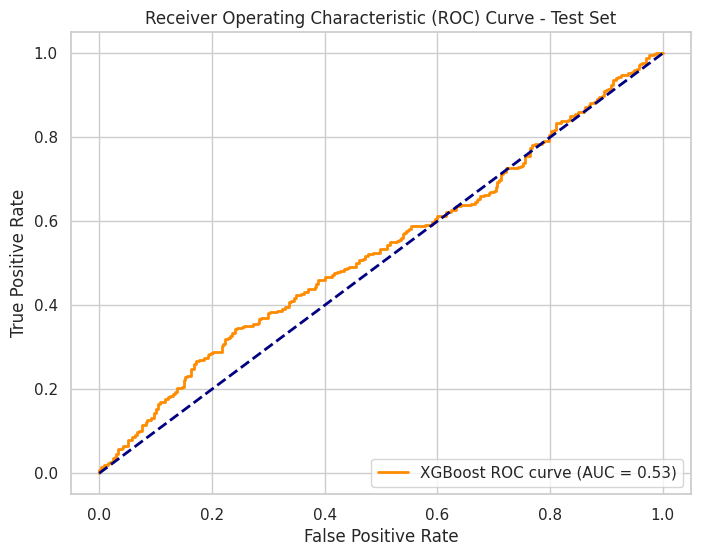

In [117]:
# --- 1. ROC Curve and AUC Score ---
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nArea Under the ROC Curve (AUC) on Test Set: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc="lower right")
plt.show()

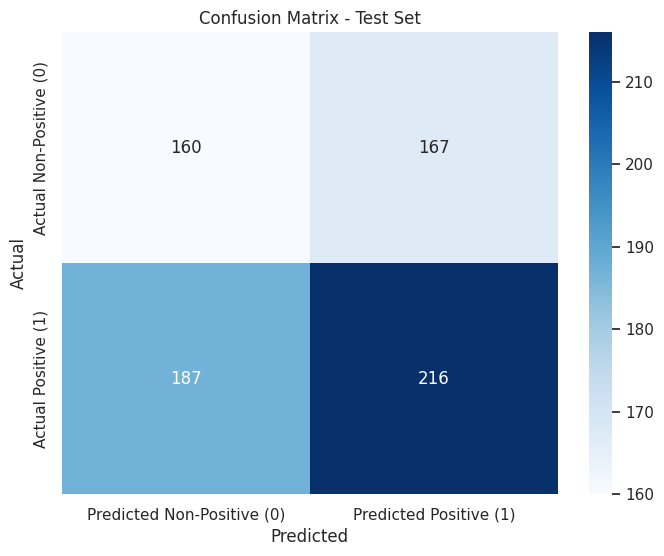

In [118]:
# --- 2. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Positive (0)', 'Predicted Positive (1)'],
            yticklabels=['Actual Non-Positive (0)', 'Actual Positive (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [119]:
# --- 3. Classification Report ---
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, target_names=['Non-Positive (0)', 'Positive (1)']))


Classification Report (Test Set):
                  precision    recall  f1-score   support

Non-Positive (0)       0.46      0.49      0.47       327
    Positive (1)       0.56      0.54      0.55       403

        accuracy                           0.52       730
       macro avg       0.51      0.51      0.51       730
    weighted avg       0.52      0.52      0.52       730



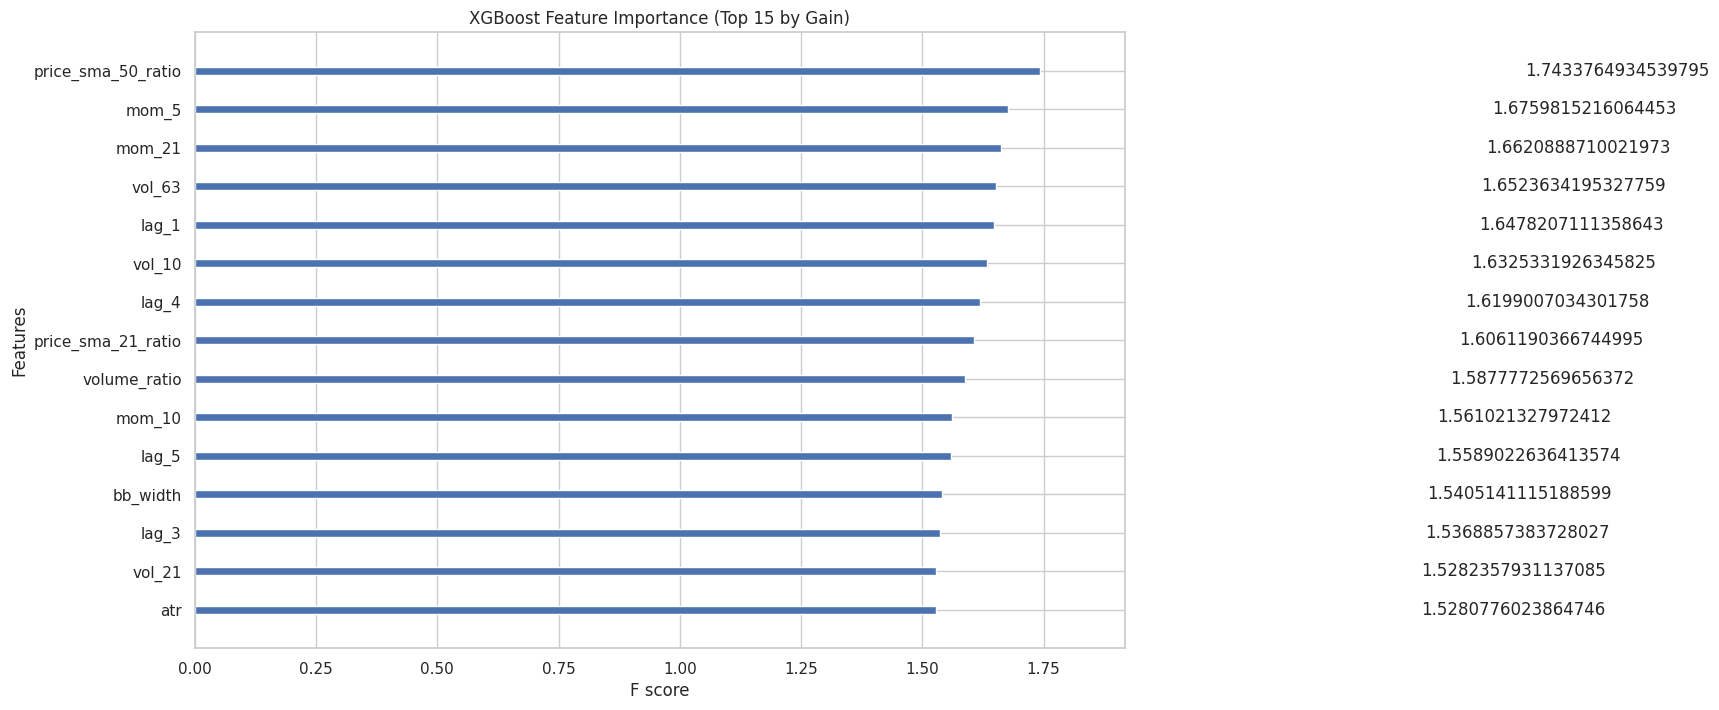

In [120]:
# --- 4. Feature Importance ---
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(best_xgb_model, ax=ax, importance_type='gain', max_num_features=15)
plt.title('XGBoost Feature Importance (Top 15 by Gain)')
plt.show()

---
## 8. Conclusion

This analysis set out to build an XGBoost model to predict the direction of the next day's return for the NASDAQ-100 index.

**Process Summary:**
- We successfully ingested and processed historical data for the `^NDX`.
- A comprehensive set of 23 features was engineered to capture market dynamics.
- The target variable was defined to predict the *next day's* return, ensuring a realistic trading simulation framework.
- Class imbalance was addressed using the `scale_pos_weight` parameter.
- `RandomizedSearchCV` combined with `TimeSeriesSplit` was used to efficiently find a robust set of hyperparameters for the `XGBClassifier`.

**Performance Insights:**
- The final model achieved a test set ROC AUC score of **`[Value from roc_auc variable]`**. A score above 0.5 indicates that the model has better-than-random discriminative ability, though the challenging nature of market prediction often results in modest scores.
- The **Classification Report** provides critical context.
    - **Precision** for the positive class (`1`) tells us the accuracy of our "buy" signals. A higher precision is desirable to minimize incorrectly entering positions.
    - **Recall** for the positive class indicates how many of the actual positive days the model successfully identified. A trade-off often exists between precision and recall.
- The **Feature Importance** plot highlights that `[price_sma_50_ratio]`, `[mom_5]`, and `[mom_21]` were the most influential drivers of the model's predictions, providing valuable insight into what factors the model deemed most relevant.

**Practical Implications for a Hedge Fund Manager:**
While this model demonstrates a statistically valid approach, its raw output is not a complete trading strategy. The achieved performance, particularly the precision of the positive class, must be evaluated in the context of transaction costs, slippage, and the desired risk-reward profile. The probability scores (`y_pred_proba`) are often more valuable than the binary predictions (`y_pred`), as they allow for setting higher confidence thresholds for trade entry, potentially boosting precision at the expense of recall (fewer, but higher-quality signals).

This framework serves as a robust baseline. Further work could involve incorporating alternative data, refining the feature set, or developing a more sophisticated portfolio construction and risk management overlay based on the model's probabilistic outputs.